In [1]:
import numpy as np
import glob
from pathlib import Path 
import scipy.io
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyresample import kd_tree, geometry
from pyresample.geometry import GridDefinition

In [2]:
nws_dir = Path('/Users/severinf/Data/raw/sic_nws/netCDF_files/') 
smos_dir=Path('/Users/severinf/Data/raw/smos_locean_arctic/')
oisst_dir=Path('/Users/severinf/Data/raw/oisst/')
fig_dir = Path('/Users/severinf/Figures/SASSIE/SASSIE-satellite/')

In [3]:
lonmin=-185
lonmax=-135
latmin=65
latmax=80
lon0=-150

latstep = 10
lonstep=30
land=True

year=2010

In [4]:
def convert_wg_time_to_td64(wg_jd_apres_ref_date, wg_ref = np.datetime64('0000-01-01')):
    """
    Input: wg_jd_apres_ref_date ==> julian date to convert
           wg_ref ==> ref date
    Output: wg_date ==> standard date
    """
    # must be integer
    wg_day_apres_ref_date = int(np.floor(wg_jd_apres_ref_date))
    # must be integer
    wg_seconds  = int(3600*24*( wg_jd_apres_ref_date - wg_day_apres_ref_date))
    wg_date = np.timedelta64(wg_day_apres_ref_date-1, 'D') + np.timedelta64(wg_seconds, 's') +  wg_ref
    return wg_date

# Sea Ice Concentration

In [5]:
files=list(nws_dir.glob('nws_'+str(year)+'*.nc'))
sic_tmp = xr.open_mfdataset(paths=files)
sic_tmp

<xarray.Dataset>
Dimensions:    (y: 1003, x: 501, z: 365)
Dimensions without coordinates: y, x, z
Data variables:
    LAT        (y, x) float64 dask.array<chunksize=(1003, 501), meta=np.ndarray>
    LON        (y, x) float64 dask.array<chunksize=(1003, 501), meta=np.ndarray>
    date       (z) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    iceconc    (z, y, x) float64 dask.array<chunksize=(365, 1003, 501), meta=np.ndarray>
    rangeconc  (z, y, x) float64 dask.array<chunksize=(365, 1003, 501), meta=np.ndarray>
    eggcode    (z, y, x) float64 dask.array<chunksize=(365, 1003, 501), meta=np.ndarray>
    flag       (z, y, x) float64 dask.array<chunksize=(365, 1003, 501), meta=np.ndarray>
    area       (z, y, x) float64 dask.array<chunksize=(365, 1003, 501), meta=np.ndarray>
    amt_poly   (z) float64 dask.array<chunksize=(365,), meta=np.ndarray>

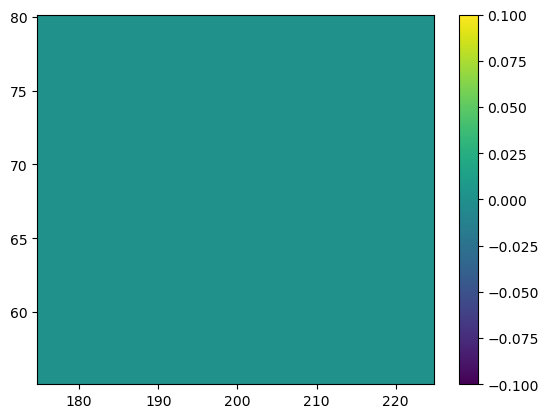

In [6]:
from netCDF4 import Dataset
root_grp = Dataset('/Users/severinf/Data/raw/sic_nws/netCDF_files/nws_'+str(year)+'.nc')
lat = np.array(root_grp.variables['LAT'][0,:])
lon = np.array(root_grp.variables['LON'][:,0])
# ind=numpy.where(lon>180)
# ind1=numpy.where(lon<=180)
# lon[ind] = lon[ind]-360
time = np.array(root_grp.variables['date'][:])
dataset = root_grp.variables['iceconc']
vvar = np.ma.array(dataset[:,:,:]).squeeze()
vvar.shape
plt.figure();plt.pcolor(lon,lat, np.transpose(vvar[243,:,:].squeeze()));plt.colorbar()

In [7]:
time_sic=np.array(sic_tmp.date.squeeze())
date_sic=[]
for itime in np.arange(np.array(sic_tmp.date.squeeze()).size):
    tmp=convert_wg_time_to_td64(time_sic[itime],wg_ref=np.datetime64('0000-01-01'))
    date_sic.append(tmp)                      
# date_sic = " ".join(str(convert_wg_time_to_td64(time_sic[itime],wg_ref=np.datetime64('0000-01-01')))[slice(0,10,1)]\
            # for itime in np.arange(np.array(mat['date'].squeeze()).size)).split()
date_sic[0]

numpy.datetime64('2010-01-01T00:30:00')

In [8]:
date_sic[243-1]

numpy.datetime64('2010-08-31T00:30:00')

In [10]:
i=242
np.transpose(sic_tmp.iceconc[i,:,:].data.squeeze()).shape

(501, 1003)

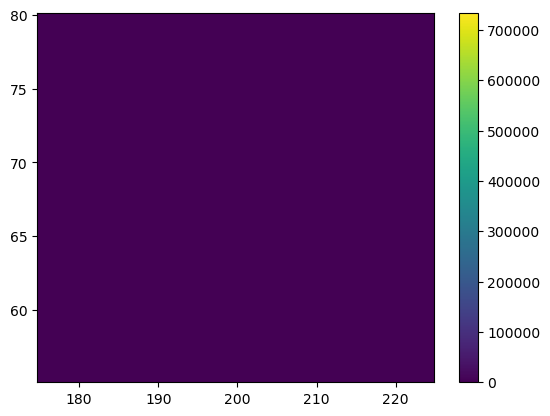

In [11]:
# raw Astrid data
i=243
plt.figure();plt.pcolor(sic_tmp.LON[:,0], sic_tmp.LAT[0,:], np.transpose(sic_tmp.iceconc[0,:,:].data.squeeze()));plt.colorbar()
# fig = plt.figure(figsize=(10,8))
# ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
# ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
# ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
# ax.coastlines('10m',zorder=2)
# ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
# gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
# gl.yformatter = LATITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
# gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
# palette = plt.cm.jet
# pp=ax.pcolormesh(sic_tmp.LON[:,0],sic_tmp.LAT[0,:],sic_tmp.iceconc[i,:,:].squeeze().values),cmap=palette,vmin=0,vmax=10,transform=cartopy.crs.PlateCarree())
# cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
# h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
# h.ax.tick_params(labelsize=20)
# h.set_label('',fontsize=20)
# cmin,cmax = h.mappable.get_clim()
# ticks = np.linspace(cmin,cmax,6)
# h.set_ticks(ticks)
# plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [13]:
#change lon to -180,180
lon=np.array(sic_tmp.LON)[:,0].squeeze()
ind=np.where(lon>180)
ind1=np.where(lon<=180)
new_lon = np.array(sic_tmp.LON)[:,0].squeeze() + 0
new_lon[ind] = new_lon[ind]-360
new_lon=np.hstack((new_lon[ind],new_lon[ind1]))

sic_all = xr.DataArray(np.transpose(np.hstack((sic_tmp.iceconc[:,ind[0],:].squeeze(),sic_tmp.iceconc[:,ind1[0],:].squeeze())), (2, 1, 0)), 
coords={'lat': np.array(sic_tmp.LAT)[0,:].squeeze(),'lon': new_lon,'time': time_sic}, 
dims=["lat", "lon", "time"])
sic_all

<xarray.DataArray (lat: 501, lon: 1003, time: 365)>
array([[[734245.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [734246.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [734247.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [734242.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [734243.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [734244.02083333,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]],

       [[     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
...
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]],

       [[     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]]])
Coordinates:
  * lat      (lat) float64 55.12 55.17 55.23 55.27 ... 79.97 80.03 80.08 80.12
  * lon      (lon) float64 -179.9 -179.9 -179.8 -179.8 ... 179.9 179.9 180.0
  * time     (time) float64 7.341e+05 7.341e+05 ... 7.345e+05 7.345e+05

In [ ]:
#mask land
ind=np.where(sic_all[:,:,363]==0)
mask_land_tmp=np.ones(sic_all[:,:,363].shape)
mask_land_tmp[ind]=0
mask_land_tmp=mask_land_tmp.reshape((mask_land_tmp.shape[0], mask_land_tmp.shape[1], 1))
mask_land=np.tile(mask_land_tmp,(1,1,sic_all.shape[2]))
sic_all=sic_all.where(mask_land)

In [ ]:
sic_all_interp=sic_all.interpolate_na(dim=('time'), method='nearest')

In [ ]:
sic_all_interp

In [ ]:
sic = xr.DataArray(np.round(sic_all_interp.data), 
coords={'lat': sic_all_interp.lat.data,'lon': sic_all_interp.lon.data,'time': date_sic}, 
dims=["lat", "lon", "time"]).sel(time=slice(str(year)+'-08-31',str(year)+'-12-30'),lat=slice(latmin,latmax),lon=slice(lonmin,lonmax))

In [ ]:
sic #check that i should do the round? do data are finite?

In [ ]:
np.transpose(sic_tmp.iceconc[i,:,:].squeeze().values).shape

In [ ]:
# raw Astrid data
for i in range(243,245):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(sic_tmp.LON[:,0].squeeze().values,sic_tmp.LAT[0,:].squeeze().values,np.transpose(sic_tmp.iceconc[i,:,:].squeeze().values),cmap=palette,vmin=0,vmax=10,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [ ]:
for i in range(243,245):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(sic_all.lon,sic_all.lat,sic_all[:,:,i].squeeze(),cmap=palette,vmin=0,vmax=10,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [ ]:
# for i in range(0,2):
#     fig = plt.figure(figsize=(10,8))
#     ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
#     ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
#     ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
#     ax.coastlines('10m',zorder=2)
#     ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
#     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
#     gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
#     gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
#     palette = plt.cm.jet
#     pp=ax.pcolormesh(sic.lon,sic.lat,sic[:,:,i].squeeze(),cmap=palette,vmin=0,vmax=10,transform=cartopy.crs.PlateCarree())
#     cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
#     h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
#     h.ax.tick_params(labelsize=20)
#     h.set_label('',fontsize=20)
#     cmin,cmax = h.mappable.get_clim()
#     ticks = np.linspace(cmin,cmax,6)
#     h.set_ticks(ticks)
#     plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [ ]:
freeze=np.zeros(sic.shape)
freeze[:]=np.nan
ind=np.where(sic.data<=1)
freeze[ind]=0
ind=np.where(sic.data>1)
freeze[ind]=1
freeze.shape

In [ ]:
mask_freeze=np.zeros(sic.shape)
ind=np.where(~np.isfinite(freeze))
mask_freeze[ind]=np.nan             
for i in range(5,sic.shape[2]+1):
    tmp=np.nansum(freeze[:,:,i-5:i],axis=2)
    ind=np.where(tmp>=5)
    tmp[:]=0
    tmp[ind]=1
    for j in np.arange(-5,0,1):
        mask_freeze[:,:,i+j]=mask_freeze[:,:,i+j]+tmp
mask_freeze[np.where(mask_freeze>=1)]=1

In [ ]:
# fig = plt.figure(figsize=(10,8))
# ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
# ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
# ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
# ax.coastlines('10m',zorder=2)
# ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
# gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
# gl.yformatter = LATITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
# gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
# palette = plt.cm.jet
# pp=ax.pcolormesh(sic.lon,sic.lat,freeze[:,:,0].squeeze(),cmap=palette,vmin=0,vmax=1,transform=cartopy.crs.PlateCarree())
# cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
# h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
# h.ax.tick_params(labelsize=20)
# h.set_label('',fontsize=20)
# cmin,cmax = h.mappable.get_clim()
# ticks = np.linspace(cmin,cmax,6)
# h.set_ticks(ticks)
# plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [ ]:
# fig = plt.figure(figsize=(10,8))
# ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
# ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
# ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
# ax.coastlines('10m',zorder=2)
# ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
# gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
# gl.yformatter = LATITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
# gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
# palette = plt.cm.jet
# pp=ax.pcolormesh(sic.lon,sic.lat,mask_freeze[:,:,0].squeeze(),cmap=palette,vmin=0,vmax=1,transform=cartopy.crs.PlateCarree())
# cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
# h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
# h.ax.tick_params(labelsize=20)
# h.set_label('',fontsize=20)
# cmin,cmax = h.mappable.get_clim()
# ticks = np.linspace(cmin,cmax,6)
# h.set_ticks(ticks)
# plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)

In [ ]:
data_vars = {'sic':(['lat','lon','time'], sic.data, {'units': 'tenth', 'long_name':'sea ice concentration in tenth'}),
             'freeze':(['lat','lon','time'], freeze, {'long_name':'pixels higher than 1 tenth in sic'}),
             'mask_freeze':(['lat','lon','time'], mask_freeze, {'long_name':'1: pixel frozen for at least 5 consecutive days, otherwise 0'})
            }
coords = {'lat': (['lat'], sic.lat.data),'lon': (['lon'], sic.lon.data),'time': (['time'], sic.time.data)}
attrs = {'creation_date':str(datetime.now().year)+'-'+str(datetime.now().month).zfill(2)+'-'+str(datetime.now().day).zfill(2), 
         'author':'Severine Fournier'}
nws = xr.Dataset(data_vars=data_vars, 
                coords=coords, 
                attrs=attrs)
nws

In [ ]:
date = pd.to_datetime(nws.time)
doy_open_first=np.empty((nws.mask_freeze.data[:,:,0].squeeze().shape))
doy_open_first[:]=np.nan
doy_open_last=np.empty((nws.mask_freeze.data[:,:,0].squeeze().shape))
doy_open_last[:]=np.nan
for i in range(nws.mask_freeze.data.shape[0]):
    for j in range(nws.mask_freeze.data.shape[1]):
        idx=np.where(nws.mask_freeze.data[i,j,:]==0) #where we have no ice
        if len(idx[0])>1:
            doy_open_first[i,j]=date.dayofyear[idx[0][0]] #doy_open_first: first day of no 'ice for at least 5 days' after September
            doy_open_last[i,j]=date.dayofyear[idx[0][-1]]+1 #doy_open_last: last day of no 'ice for at least 5 days' after September

In [ ]:
doy_start=date.dayofyear[0]
doy_freeze_first=np.empty((nws.mask_freeze.data[:,:,0].squeeze().shape))
doy_freeze_first[:]=np.nan
for i in range(nws.mask_freeze.data.shape[0]):
    for j in range(nws.mask_freeze.data.shape[1]):
        idx=np.where(nws.mask_freeze.data[i,j,:]==1)[0] #where we have ice
        if len(idx)>1 and np.isfinite(doy_open_first[i,j]):
            idx=np.delete(idx,np.where(idx<=int(doy_open_first[i,j]-doy_start)))
            if len(idx)>1: #otherwise it means it never freezes past the first day of open after september
                doy_freeze_first[i,j]=date.dayofyear[idx[0]] #first day of 'ice for at least 5 days' after 'first day of no 'ice for at least 5 days'

In [ ]:
# Map of the first day of no 'ice for at least 5 days' after September

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax.coastlines('10m',zorder=2)
ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
palette = plt.cm.jet
pp=ax.pcolormesh(nws.lon,nws.lat,doy_open_first,cmap=palette,vmin=243,vmax=365,transform=cartopy.crs.PlateCarree())
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
h.ax.tick_params(labelsize=20)
h.set_label('',fontsize=20)
cmin,cmax = h.mappable.get_clim()
ticks = np.linspace(cmin,cmax,6)
h.set_ticks(ticks)
plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
fig_name='map_day1noice_after09'+str(year)+'.png'
plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map of the last day of no 'ice for at least 5 days' after September

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax.coastlines('10m',zorder=2)
ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
palette = plt.cm.jet
pp=ax.pcolormesh(nws.lon,nws.lat,doy_open_last,cmap=palette,vmin=243,vmax=365,transform=cartopy.crs.PlateCarree())
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
h.ax.tick_params(labelsize=20)
h.set_label('',fontsize=20)
cmin,cmax = h.mappable.get_clim()
ticks = np.linspace(cmin,cmax,6)
h.set_ticks(ticks)
plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
fig_name='map_daylastnoice_after09'+str(year)+'.png'
plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map first day of 'ice for at least 5 days' after 'first day of no 'ice for at least 5 days'

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax.coastlines('10m',zorder=2)
ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
palette = plt.cm.jet
pp=ax.pcolormesh(nws.lon,nws.lat,doy_freeze_first,cmap=palette,vmin=243,vmax=365,transform=cartopy.crs.PlateCarree())
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
h.ax.tick_params(labelsize=20)
h.set_label('',fontsize=20)
cmin,cmax = h.mappable.get_clim()
ticks = np.linspace(cmin,cmax,6)
h.set_ticks(ticks)
plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
fig_name='map_day1ice_afterday1noice.png'
plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map of the difference:
# last day of no 'ice for at least 5 days' after September
# minus first day of 'ice for at least 5 days' after 'first day of no 'ice for at least 5 days'

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax.coastlines('10m',zorder=2)
ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
palette = plt.cm.jet
pp=ax.pcolormesh(nws.lon,nws.lat,doy_open_last-doy_freeze_first,cmap=palette,vmin=0,vmax=50,transform=cartopy.crs.PlateCarree())
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
h.ax.tick_params(labelsize=20)
h.set_label('',fontsize=20)
cmin,cmax = h.mappable.get_clim()
ticks = np.linspace(cmin,cmax,6)
h.set_ticks(ticks)
plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
fig_name='map_diff_daylastnoice_after09'+str(year)+'-day1ice_afterday1noice.png'
plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

# Sea Surface Temperature and Salinity

In [ ]:
files=list(oisst_dir.glob('oisst_'+str(year)+'*.nc'))
files=np.sort(files)
tmp = xr.open_mfdataset(paths=files).sel(time=slice(str(year)+'-08-31',str(year)+'-12-30'),lat=slice(latmin,latmax),zlev=0)
tmp=tmp.drop('zlev')
tmp

In [ ]:
new_lon = tmp.lon.values + 0
new_lon[new_lon > 180] = new_lon[new_lon > 180]-360
tmp=tmp.drop('lon')
tmp=tmp.assign_coords({'lon': new_lon})

D = tmp.anom[:,:,180:]
C = tmp.anom[:,:,0:180:]
F = tmp.ice[:,:,180:]
E = tmp.ice[:,:,0:180:]
H = tmp.err[:,:,180:]
G = tmp.err[:,:,0:180:]

B = tmp.sst[:,:,180:]
A = tmp.sst[:,:,0:180:]
oisst = xr.merge([B, A]).transpose('lat','lon','time')

In [ ]:
oisst = oisst.assign(
    anom=(['lat','lon','time'],xr.merge([D, C]).transpose('lat','lon','time').anom.data),
    ice=(['lat','lon','time'],xr.merge([F, E]).transpose('lat','lon','time').ice.data), 
    err=(['lat','lon','time'],xr.merge([H, G]).transpose('lat','lon','time').err.data),
                    )
oisst.anom.attrs['long_name'] = tmp.anom.attrs['long_name']
oisst.anom.attrs['units'] = tmp.anom.attrs['units']
oisst.anom.attrs['valid_min'] = tmp.anom.attrs['valid_min']
oisst.anom.attrs['valid_max'] = tmp.anom.attrs['valid_max']

oisst.ice.attrs['long_name'] = tmp.ice.attrs['long_name']
oisst.ice.attrs['units'] = tmp.ice.attrs['units']
oisst.ice.attrs['valid_min'] = tmp.ice.attrs['valid_min']
oisst.ice.attrs['valid_max'] = tmp.ice.attrs['valid_max']

oisst.err.attrs['long_name'] = tmp.err.attrs['long_name']
oisst.err.attrs['units'] = tmp.err.attrs['units']
oisst.err.attrs['valid_min'] = tmp.err.attrs['valid_min']
oisst.err.attrs['valid_max'] = tmp.err.attrs['valid_max']
oisst

In [ ]:
files=list(smos_dir.glob('SMOS_L3_DEBIAS_LOCEAN_AD_'+str(year)+'*.nc'))
files=np.sort(files)
smos = xr.open_mfdataset(paths=files).sel(time=slice(str(year)+'-08-31',str(year)+'-12-30'))
smos

## Interpolation on NWS grid

In [ ]:
longrid_nws=nws.lon
latgrid_nws=nws.lat
[LOgrid_nws,LAgrid_nws]=np.meshgrid(longrid_nws,latgrid_nws)
longrid_oisst=oisst.lon
latgrid_oisst=oisst.lat
[LOgrid_oisst,LAgrid_oisst]=np.meshgrid(longrid_oisst,latgrid_oisst)

nws_def = geometry.GridDefinition(lons=LOgrid_nws, lats=LAgrid_nws)
smos_def = geometry.GridDefinition(lons=smos.lon[0,:,:].squeeze().data, lats=smos.lat[0,:,:].squeeze().data) 
oisst_def = geometry.GridDefinition(lons=LOgrid_oisst, lats=LAgrid_oisst)  

smos_regrid=[]
for i in range(0,smos.SSS.shape[0]):
    tmp=np.array(smos.SSS[i,:,:].squeeze().data)
    tmp_grid = kd_tree.resample_nearest(smos_def, tmp, nws_def, radius_of_influence=100000, fill_value=np.nan) #10km?
    try:
        smos_regrid=np.dstack((smos_regrid,tmp_grid))
    except:
        smos_regrid=tmp_grid

oisst_regrid=[]
for i in range(0,oisst.sst.shape[2]):
    tmp=np.array(oisst.sst[:,:,i].squeeze().data)
    tmp_grid = kd_tree.resample_nearest(oisst_def, tmp, nws_def, radius_of_influence=100000, fill_value=np.nan) #10km?
    try:
        oisst_regrid=np.dstack((oisst_regrid,tmp_grid))
    except:
        oisst_regrid=tmp_grid

In [ ]:
# plt.figure();plt.pcolor(longrid_nws, latgrid_nws, smos_regrid[:,:,10]);plt.colorbar()
# plt.figure();plt.pcolor(longrid_nws, latgrid_nws, oisst_regrid[:,:,10]);plt.colorbar()

In [ ]:
sal_beforefirstfreeze=np.empty(([nws.sic[:,:,0].shape[0],nws.sic[:,:,0].shape[1],8]))
sal_beforefirstfreeze[:]=np.nan    
temp_beforefirstfreeze=np.empty(([nws.sic[:,:,0].shape[0],nws.sic[:,:,0].shape[1],8]))
temp_beforefirstfreeze[:]=np.nan  

for i in range(0,len(nws.lat)):
    for j in range(0,len(nws.lon)):
        if np.isfinite(doy_freeze_first[i,j]):
            for k in range(1,9):
                sal_beforefirstfreeze[i,j,k-1]=smos_regrid[i,j,int(doy_freeze_first[i,j]-k-date.dayofyear[0])]
                temp_beforefirstfreeze[i,j,k-1]=oisst_regrid[i,j,int(doy_freeze_first[i,j]-k-date.dayofyear[0])]

In [ ]:
sal_beforelastfreeze=np.empty(([nws.sic[:,:,0].shape[0],nws.sic[:,:,0].shape[1],8]))
sal_beforelastfreeze[:]=np.nan    
temp_beforelastfreeze=np.empty(([nws.sic[:,:,0].shape[0],nws.sic[:,:,0].shape[1],8]))
temp_beforelastfreeze[:]=np.nan  

for i in range(0,len(nws.lat)):
    for j in range(0,len(nws.lon)):
        if np.isfinite(doy_freeze_first[i,j]):
            for k in range(0,8):
                sal_beforelastfreeze[i,j,k-1]=smos_regrid[i,j,int(doy_open_last[i,j]-k-date.dayofyear[0])]
                temp_beforelastfreeze[i,j,k-1]=oisst_regrid[i,j,int(doy_open_last[i,j]-k-date.dayofyear[0])]

In [ ]:
# Map of salinity one day to a week before the first freeze up in the fall:

for k in range(0,8):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(nws.lon,nws.lat,sal_beforefirstfreeze[:,:,k].squeeze(),cmap=palette,vmin=20,vmax=33,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
    fig_name='map_sal_beforefirstfreeze_'+str(year)+'_day-'+str(k+1)+'.png'
    plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map of temperature one day to a week before the first freeze up in the fall:

for k in range(0,8):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(nws.lon,nws.lat,temp_beforefirstfreeze[:,:,k].squeeze(),cmap=palette,vmin=-2,vmax=7,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
    fig_name='map_temp_beforefirstfreeze_'+str(year)+'_day-'+str(k+1)+'.png'
    plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map of salinity one day to a week before the last freeze up in the fall:

for k in range(0,8):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(nws.lon,nws.lat,sal_beforelastfreeze[:,:,k].squeeze(),cmap=palette,vmin=20,vmax=33,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
    fig_name='map_sal_beforelastfreeze_'+str(year)+'_day-'+str(k+1)+'.png'
    plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')

In [ ]:
# Map of temperature one day to a week before the last freeze up in the fall:

for k in range(0,8):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,15))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin,latmax,5))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    palette = plt.cm.jet
    pp=ax.pcolormesh(nws.lon,nws.lat,temp_beforelastfreeze[:,:,k].squeeze(),cmap=palette,vmin=-2,vmax=7,transform=cartopy.crs.PlateCarree())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
    h.ax.tick_params(labelsize=20)
    h.set_label('',fontsize=20)
    cmin,cmax = h.mappable.get_clim()
    ticks = np.linspace(cmin,cmax,6)
    h.set_ticks(ticks)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.95,bottom=0.18)
    fig_name='map_temp_beforelastfreeze_'+str(year)+'_day-'+str(k+1)+'.png'
    plt.savefig(fig_dir / fig_name,dpi=200,transparent=False,facecolor='white')